In [18]:

import random
import numpy as np
import pandas as pd
import sklearn
import pickle
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation

In [19]:
SEED = 2022
random.seed(SEED)
np.random.seed(SEED)

In [20]:
dataset = pd.read_csv('android.csv')

     

In [21]:
Y = dataset['class']
X = dataset.drop(['class'], axis=1)
features = X.columns


In [22]:

encoder = LabelEncoder().fit(Y)
Y = encoder.transform(Y)
     

In [23]:

np.array(X)
     

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [24]:
est = SVC()
score = -1.0 * cross_val_score(est, X, Y, cv=5, scoring="neg_mean_squared_error")
print("CV MSE before feature selection: {:.2f}".format(np.mean(score)))

CV MSE before feature selection: 0.11


In [32]:
class GeneticSelector():
    def __init__(self, estimator, n_gen, size, n_best, n_rand, 
                 n_children, mutation_rate):
        # Estimator 
        self.estimator = estimator
        # Number of generations
        self.n_gen = n_gen
        # Number of chromosomes in population
        self.size = size
        # Number of best chromosomes to select
        self.n_best = n_best
        # Number of random chromosomes to select
        self.n_rand = n_rand
        # Number of children created during crossover
        self.n_children = n_children
        # Probablity of chromosome mutation
        self.mutation_rate = mutation_rate
        
        if int((self.n_best + self.n_rand) / 2) * self.n_children != self.size:
            raise ValueError("The population size is not stable.")  
            
    def initilize(self):
        population = []
        for i in range(self.size):
            chromosome = np.ones(self.n_features, dtype=bool)
            mask = np.random.rand(len(chromosome)) < 0.3
            chromosome[mask] = False
            population.append(chromosome)
        return population

    def fitness(self, population):
        X, y = self.dataset
        scores = []
        for chromosome in population:
            score = -1.0 * np.mean(cross_val_score(self.estimator, X[:,chromosome], y, 
                                                       cv=5, 
                                                       scoring="neg_mean_squared_error"))
            scores.append(score)
        scores, population = np.array(scores), np.array(population) 
        inds = np.argsort(scores)
        return list(scores[inds]), list(population[inds,:])

    def select(self, population_sorted):
        population_next = []
        for i in range(self.n_best):
            population_next.append(population_sorted[i])
        for i in range(self.n_rand):
            population_next.append(random.choice(population_sorted))
        random.shuffle(population_next)
        return population_next

    def crossover(self, population):
        population_next = []
        for i in range(int(len(population)/2)):
            for j in range(self.n_children):
                chromosome1, chromosome2 = population[i], population[len(population)-1-i]
                child = chromosome1
                mask = np.random.rand(len(child)) > 0.5
                child[mask] = chromosome2[mask]
                population_next.append(child)
        return population_next
	
    def mutate(self, population):
        population_next = []
        for i in range(len(population)):
            chromosome = population[i]
            if random.random() < self.mutation_rate:
                mask = np.random.rand(len(chromosome)) < 0.05
                chromosome[mask] = False
            population_next.append(chromosome)
        return population_next

    def generate(self, population):
        # Selection, crossover and mutation
        scores_sorted, population_sorted = self.fitness(population)
        population = self.select(population_sorted)
        population = self.crossover(population)
        population = self.mutate(population)
        # History
        self.chromosomes_best.append(population_sorted[0])
        self.scores_best.append(scores_sorted[0])
        self.scores_avg.append(np.mean(scores_sorted))
        
        return population

    def fit(self, X, y):
 
        self.chromosomes_best = []
        self.scores_best, self.scores_avg  = [], []
        
        self.dataset = X, y
        self.n_features = X.shape[1]
        g = 1
        population = self.initilize()
        for i in range(self.n_gen):
            population = self.generate(population)
            print('generation:', g)
            g+=1
        return self 
    
    @property
    def support_(self):
        return self.chromosomes_best[-1]

    def plot_scores(self):
        plt.plot(self.scores_best, label='Best')
        plt.plot(self.scores_avg, label='Average')
        plt.legend()
        plt.ylabel('Scores')
        plt.xlabel('Generation')
        plt.show()
     

generation: 1
generation: 2
generation: 3
generation: 4
generation: 5
generation: 6
generation: 7


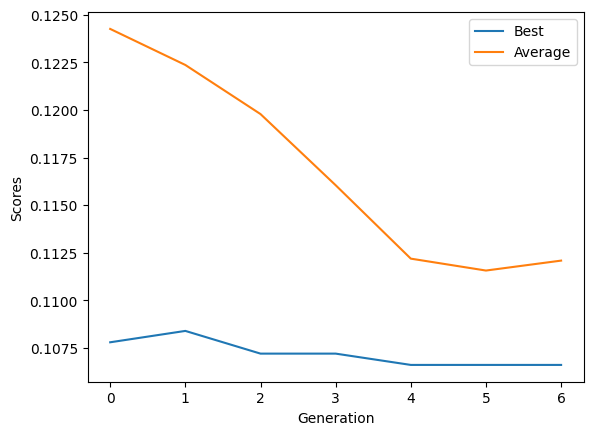

In [35]:
import numpy as np
from sklearn.svm import SVC

# Assuming X is a NumPy array and Y is the target
sel = GeneticSelector(estimator=SVC(), 
                      n_gen=7, size=200, n_best=40, n_rand=40, 
                      n_children=5, mutation_rate=0.05)
sel.fit(X, Y)
sel.plot_scores()

In [36]:

score = -1.0 * cross_val_score(est, X[:,sel.support_], Y, cv=5, scoring="neg_mean_squared_error")
print("CV MSE after feature selection: {:.2f}".format(np.mean(score)))

CV MSE after feature selection: 0.11


In [37]:
import pickle
pickle.dump(sel, open('ga.pkl', 'wb'))
     

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [55]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Assuming X_train and X_test are your training and testing data
# Also assuming sel is your feature selector

# Create the model
AN = Sequential()
AN.add(Dense(256, input_dim=X_train[:, sel.support_].shape[1], activation='relu'))  # Update input_dim to match the number of features
AN.add(Dropout(0.2))
AN.add(Dense(128, activation='relu'))
AN.add(Dropout(0.2))
AN.add(Dense(128, activation='relu'))
AN.add(Dropout(0.3))
AN.add(Dense(32, activation='relu'))
AN.add(Dropout(0.2))
AN.add(Dense(1, activation='sigmoid'))
AN.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
AN.fit(X_train[:, sel.support_], y_train, epochs=175, batch_size=32)

# Evaluate on the test set
scores = AN.evaluate(X_test[:, sel.support_], y_test)

# Print the evaluation metrics
for i in range(len(scores)):
    print("\n%s: %.2f%%" % (AN.metrics_names[i], scores[i] * 100))



Epoch 1/175
42/42 [==============================] - 2s 5ms/step - loss: 0.6734 - accuracy: 0.6664
Epoch 2/175
42/42 [==============================] - 0s 4ms/step - loss: 0.6488 - accuracy: 0.6821
Epoch 3/175
42/42 [==============================] - 0s 4ms/step - loss: 0.6388 - accuracy: 0.6828
Epoch 4/175
42/42 [==============================] - 0s 4ms/step - loss: 0.6229 - accuracy: 0.6821
Epoch 5/175
42/42 [==============================] - 0s 4ms/step - loss: 0.6164 - accuracy: 0.6783
Epoch 6/175
42/42 [==============================] - 0s 4ms/step - loss: 0.5964 - accuracy: 0.6835
Epoch 7/175
42/42 [==============================] - 0s 4ms/step - loss: 0.5832 - accuracy: 0.6932
Epoch 8/175
42/42 [==============================] - 0s 4ms/step - loss: 0.5747 - accuracy: 0.6917
Epoch 9/175
42/42 [==============================] - 0s 4ms/step - loss: 0.5545 - accuracy: 0.7223
Epoch 10/175
42/42 [==============================] - 0s 4ms/step - loss: 0.5299 - accuracy: 0.7372
Epoch 11/

42/42 [==============================] - 0s 4ms/step - loss: 0.2633 - accuracy: 0.9129
Epoch 84/175
42/42 [==============================] - 0s 4ms/step - loss: 0.2597 - accuracy: 0.9039
Epoch 85/175
42/42 [==============================] - 0s 4ms/step - loss: 0.2490 - accuracy: 0.9151
Epoch 86/175
42/42 [==============================] - 0s 4ms/step - loss: 0.2451 - accuracy: 0.9077
Epoch 87/175
42/42 [==============================] - 0s 4ms/step - loss: 0.2458 - accuracy: 0.9025
Epoch 88/175
42/42 [==============================] - 0s 4ms/step - loss: 0.2529 - accuracy: 0.9106
Epoch 89/175
42/42 [==============================] - 0s 4ms/step - loss: 0.2402 - accuracy: 0.9106
Epoch 90/175
42/42 [==============================] - 0s 3ms/step - loss: 0.2428 - accuracy: 0.9106
Epoch 91/175
42/42 [==============================] - 0s 3ms/step - loss: 0.2366 - accuracy: 0.9121
Epoch 92/175
42/42 [==============================] - 0s 3ms/step - loss: 0.2409 - accuracy: 0.9121
Epoch 93/175


42/42 [==============================] - 0s 3ms/step - loss: 0.1717 - accuracy: 0.9412
Epoch 165/175
42/42 [==============================] - 0s 3ms/step - loss: 0.1616 - accuracy: 0.9427
Epoch 166/175
42/42 [==============================] - 0s 3ms/step - loss: 0.1644 - accuracy: 0.9397
Epoch 167/175
42/42 [==============================] - 0s 3ms/step - loss: 0.1571 - accuracy: 0.9427
Epoch 168/175
42/42 [==============================] - 0s 3ms/step - loss: 0.1563 - accuracy: 0.9427
Epoch 169/175
42/42 [==============================] - 0s 3ms/step - loss: 0.1642 - accuracy: 0.9375
Epoch 170/175
42/42 [==============================] - 0s 3ms/step - loss: 0.1633 - accuracy: 0.9404
Epoch 171/175
42/42 [==============================] - 0s 3ms/step - loss: 0.1612 - accuracy: 0.9382
Epoch 172/175
42/42 [==============================] - 0s 3ms/step - loss: 0.1521 - accuracy: 0.9442
Epoch 173/175
42/42 [==============================] - 0s 3ms/step - loss: 0.1551 - accuracy: 0.9464
Epoc

In [58]:

from androguard.core.bytecodes.apk import APK

def predict(apk):
  vector = {}
  a = APK(apk)
  perm = a.get_permissions()
  print(perm)
  for d in features:
    if d in perm:
      vector[d]=1
    else:
      vector[d]=0
  data = [ v for v in vector.values() ]
  data = np.array(data)
  # print(data[sel.support_])
  print(AN.predict([[data[sel.support_]]]))

#predict('/content/drive/My Drive/Android-Malware-Detection/dataset/malign/com.prasesfee.apk')
#predict(r'C:\Users\PC\Desktop\create\com.gbwhatsapp_v2.23.23.78-2147483647_Android-5.0.apk')

In [59]:
pickle.dump(AN, open('ANN_GA.pkl', 'wb'))


In [60]:

Y = dataset['class']
X = dataset.drop(['class'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
     


In [61]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
			'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
			'kernel': ['rbf','sigmoid', 'linear']} 

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
# fitting the model for grid search 
grid.fit(X_train.loc[:, sel.support_], y_train)
     

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.691 total time=   0.1s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.695 total time=   0.1s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.703 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.701 total time=   0.1s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.698 total time=   0.0s
[CV 1/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.654 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.680 total time=   0.0s
[CV 3/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.669 total time=   0.0s
[CV 4/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.668 total time=   0.0s
[CV 5/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.687 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.814 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear

[CV 3/5] END .....C=1, gamma=0.1, kernel=linear;, score=0.866 total time=   0.0s
[CV 4/5] END .....C=1, gamma=0.1, kernel=linear;, score=0.862 total time=   0.0s
[CV 5/5] END .....C=1, gamma=0.1, kernel=linear;, score=0.821 total time=   0.0s
[CV 1/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.777 total time=   0.0s
[CV 2/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.840 total time=   0.0s
[CV 3/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.844 total time=   0.0s
[CV 4/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.825 total time=   0.0s
[CV 5/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.847 total time=   0.0s
[CV 1/5] END ...C=1, gamma=0.01, kernel=sigmoid;, score=0.755 total time=   0.0s
[CV 2/5] END ...C=1, gamma=0.01, kernel=sigmoid;, score=0.818 total time=   0.0s
[CV 3/5] END ...C=1, gamma=0.01, kernel=sigmoid;, score=0.836 total time=   0.0s
[CV 4/5] END ...C=1, gamma=0.01, kernel=sigmoid;, score=0.825 total time=   0.0s
[CV 5/5] END ...C=1, gamma=0

[CV 5/5] END .C=10, gamma=0.001, kernel=sigmoid;, score=0.828 total time=   0.0s
[CV 1/5] END ..C=10, gamma=0.001, kernel=linear;, score=0.818 total time=   0.0s
[CV 2/5] END ..C=10, gamma=0.001, kernel=linear;, score=0.870 total time=   0.0s
[CV 3/5] END ..C=10, gamma=0.001, kernel=linear;, score=0.859 total time=   0.0s
[CV 4/5] END ..C=10, gamma=0.001, kernel=linear;, score=0.836 total time=   0.0s
[CV 5/5] END ..C=10, gamma=0.001, kernel=linear;, score=0.825 total time=   0.0s
[CV 1/5] END ....C=10, gamma=0.0001, kernel=rbf;, score=0.710 total time=   0.0s
[CV 2/5] END ....C=10, gamma=0.0001, kernel=rbf;, score=0.729 total time=   0.1s
[CV 3/5] END ....C=10, gamma=0.0001, kernel=rbf;, score=0.710 total time=   0.0s
[CV 4/5] END ....C=10, gamma=0.0001, kernel=rbf;, score=0.739 total time=   0.0s
[CV 5/5] END ....C=10, gamma=0.0001, kernel=rbf;, score=0.724 total time=   0.1s
[CV 1/5] END C=10, gamma=0.0001, kernel=sigmoid;, score=0.684 total time=   0.0s
[CV 2/5] END C=10, gamma=0.0

[CV 4/5] END ...C=1000, gamma=1, kernel=sigmoid;, score=0.575 total time=   0.0s
[CV 5/5] END ...C=1000, gamma=1, kernel=sigmoid;, score=0.575 total time=   0.0s
[CV 1/5] END ....C=1000, gamma=1, kernel=linear;, score=0.814 total time=   7.5s
[CV 2/5] END ....C=1000, gamma=1, kernel=linear;, score=0.870 total time=   6.7s
[CV 3/5] END ....C=1000, gamma=1, kernel=linear;, score=0.870 total time=   3.3s
[CV 4/5] END ....C=1000, gamma=1, kernel=linear;, score=0.843 total time=   3.3s
[CV 5/5] END ....C=1000, gamma=1, kernel=linear;, score=0.843 total time=   2.2s
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.870 total time=   0.0s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.877 total time=   0.0s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.885 total time=   0.0s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.907 total time=   0.0s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.877 total time=   0.0s
[CV 1/5] END .C=1000, gamma=

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'sigmoid', 'linear']},
             verbose=3)

In [62]:
print(grid.best_params_) 
grid_predictions = grid.predict(X_test.loc[:,sel.support_]) 

# print classification report 
print(classification_report(y_test, grid_predictions)) 
pickle.dump(grid, open('svc_ga.pkl', 'wb'))

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

      benign       0.88      0.89      0.89       229
      malign       0.76      0.74      0.75       107

    accuracy                           0.84       336
   macro avg       0.82      0.81      0.82       336
weighted avg       0.84      0.84      0.84       336



In [63]:
def predict(apk):
  vector = {}
  a = APK(apk)
  perm = a.get_permissions()
  print(perm)
  for d in features:
    if d in perm:
      vector[d]=1
    else:
      vector[d]=0
  data = [ v for v in vector.values() ]
  data = np.array(data)
  print(grid.predict([data[sel.support_]]))

#predict('/content/Ransomware/PornDroid/1c53e2c34d1219a2fae8fcf8ec872ac8.apk')
#predict('/content/drive/My Drive/Android-Malware-Detection/dataset/benign/com.whatsapp.apk')